In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def running_avg(x):
    return np.cumsum(x) / np.arange(1, x.size + 1)

def running_timeavg(t,x):
    dt = t[1:] - t[:-1]
    x = np.cumsum(x[:-1] * dt)
    y = t[1:]
    return [a/b for a,b in zip(x,y)]

def filter_vec(df, name):
    x = df[(df.name == name + ":vector") & (df.type == "vector")] #.filter(["vectime","vecvalue"])
    return x #pd.DataFrame(index=x.vectime.values[0], data={name : x.vecvalue.values[0]})
    
#for i in range(1,len(vec)):
#    row = vec.iloc[i]
#    row = pd.DataFrame(index=row.vectime, data={data_name : row.vecvalue})
#    mean_res = pd.concat((mean_res, row)    
#mean_res = mean_res_dc.groupby(level=0).mean()

## Caso DC - Recursos

In [2]:
# Cargamos los datos
targetDcRes = pd.read_csv("targetDcRes.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetDcRes[targetDcRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
67,targetDc-0-20240613-18:16:27-68423,vector,MediumNet.dc.resourceManager,allocatedVms:vector,NaN,None,NaN,"[82.685518416264, 83.355780093655, 83.62520308...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
70,targetDc-0-20240613-18:16:27-68423,vector,MediumNet.dc.resourceManager,allocatedCores:vector,NaN,None,NaN,"[82.685518416264, 83.355780093655, 83.62520308...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
73,targetDc-0-20240613-18:16:27-68423,vector,MediumNet.dc.resourceManager,allocatedRam:vector,NaN,None,NaN,"[82.685518416264, 83.355780093655, 83.62520308...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
77,targetDc-0-20240613-18:16:27-68423,vector,MediumNet.dc.resourceManager,allocatedDisk:vector,NaN,None,NaN,"[82.685518416264, 83.355780093655, 83.62520308...","[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250..."


In [3]:
def process_vector(df, data_name: str):
    # Empezamos el proceso de merging del conjunto de datos
    row = df.iloc[0]
    print(type(row.vectime))
    print(type(row.vecvalue))
    
    times = np.append([0], row.vectime)
    times = np.append(times, [3600])
    
    # Accumulate the values
    values = np.cumsum(row.vecvalue)
    values = np.append([0], values)
    values = np.append(values, max(values))
    
    vec = pd.DataFrame(index=times, data={data_name : values})
    
    return vec

In [4]:
res_dc = dict()
res_dc["vms"] = process_vector(filter_vec(targetDcRes, "allocatedVms"), "vms")
res_dc["ram"] = process_vector(filter_vec(targetDcRes, "allocatedRam"), "ram")
res_dc["disk"] = process_vector(filter_vec(targetDcRes, "allocatedDisk"), "disk")
res_dc["cpus"] = process_vector(filter_vec(targetDcRes, "allocatedCores"), "cpus")
res_dc["vms"]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


,vms
0.000000,0.0
82.685518,1.0
83.355780,2.0
83.625203,3.0
84.471137,4.0
84.709226,5.0
85.835487,6.0
87.502206,7.0
87.554552,8.0
87.999813,9.0


## Gráficas

In [8]:
n_blades = 20
dc_max_vms = n_blades *  16
dc_max_ram = n_blades *  64
dc_max_disk = n_blades * 4000
dc_max_cpus = n_blades * 16

In [6]:
def plot_under_curve(axis, x, y ,color):
    axis.plot(x,y, color=color)
    axis.fill_between(x,y.reshape(-1),0, color=color, alpha=.1)

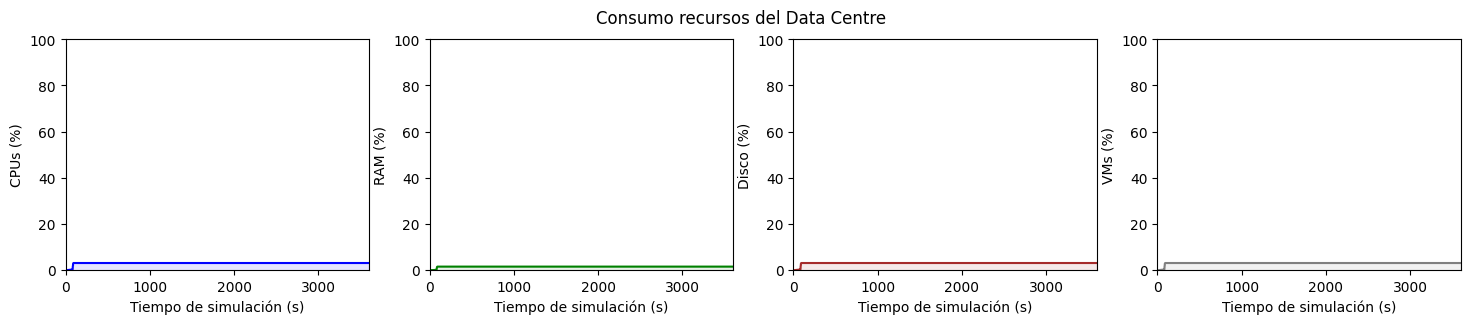

In [9]:
fig, (ax) = plt.subplots(1, 4)
fig.suptitle('Consumo recursos del Data Centre')

fig.set_size_inches(18, 3)

ax[0].set(ylabel='CPUs (%)')
ax[1].set(ylabel='RAM (%)')
ax[2].set(ylabel='Disco (%)')
ax[3].set(ylabel='VMs (%)')

#ax[0].plot(res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_vms) * 100)
#ax[0].fill_between(res_dc["cpus"].index.to_numpy(), (res_dc["cpus"].values.reshape(-1) / dc_max_vms) * 100, 0, color='blue', alpha=.1)

plot_under_curve(ax[0], res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_vms) * 100, "blue")
plot_under_curve(ax[1], res_dc["ram"].index, (res_dc["ram"].values / dc_max_ram) * 100, "green")
plot_under_curve(ax[2], res_dc["disk"].index, (res_dc["disk"].values / dc_max_disk) * 100, "brown")
plot_under_curve(ax[3], res_dc["vms"].index, (res_dc["vms"].values / dc_max_vms) * 100, "gray")

#plt.title("Uso de máquinas virtuales (DC)")

#plt.ylabel("Máquinas virtuales")
#plt.xlabel("tiempo simulado [s]")
for x in ax:
    x.set_ylim(0,100)
    x.set_xlim(0,3600)
    x.set(xlabel='Tiempo de simulación (s)')

#plt.xlim(0,3600)
#plt.plot(res_dc["vms"])
#plt.show()

## Caso Fog - Recursos

In [35]:
# Cargamos los datos
targetFogRes = pd.read_csv("targetFogRes.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetFogRes[targetFogRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
70,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg4.resourceManager,allocatedVms:vector,NaN,None,NaN,"[82.659229824972, 84.520481231077, 87.85033201...","[1.0, 1.0, 1.0]"
73,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg4.resourceManager,allocatedCores:vector,NaN,None,NaN,"[82.659229824972, 84.520481231077, 87.85033201...","[1.0, 1.0, 1.0]"
76,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg4.resourceManager,allocatedRam:vector,NaN,None,NaN,"[82.659229824972, 84.520481231077, 87.85033201...","[2.0, 2.0, 2.0]"
80,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg4.resourceManager,allocatedDisk:vector,NaN,None,NaN,"[82.659229824972, 84.520481231077, 87.85033201...","[250.0, 250.0, 250.0]"
84,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg3.resourceManager,allocatedVms:vector,NaN,None,NaN,"[83.315005170873, 83.417780439256, 85.47928531...","[1.0, 1.0, 1.0]"
87,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg3.resourceManager,allocatedCores:vector,NaN,None,NaN,"[83.315005170873, 83.417780439256, 85.47928531...","[1.0, 1.0, 1.0]"
90,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg3.resourceManager,allocatedRam:vector,NaN,None,NaN,"[83.315005170873, 83.417780439256, 85.47928531...","[2.0, 2.0, 2.0]"
94,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg3.resourceManager,allocatedDisk:vector,NaN,None,NaN,"[83.315005170873, 83.417780439256, 85.47928531...","[250.0, 250.0, 250.0]"
98,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg2.resourceManager,allocatedVms:vector,NaN,None,NaN,"[84.323569073189, 84.372392876976]","[1.0, 1.0]"
101,targetFog-0-20240613-18:16:45-68498,vector,MediumNet.fg2.resourceManager,allocatedCores:vector,NaN,None,NaN,"[84.323569073189, 84.372392876976]","[1.0, 1.0]"


In [47]:
def process_vector2(df, data_name: str):
    vecs = []
    # Empezamos el proceso de merging del conjunto de datos
    ordered = df.sort_values(["module"])
    for i in range(0,len(df)):
        row = ordered.iloc[i]
    
        times = np.append([0], row.vectime)
        times = np.append(times, [3600])
    
        # Accumulate the values
        values = np.cumsum(row.vecvalue)
        values = np.append([0], values)
        values = np.append(values, max(values))
    
        vecs.append(pd.DataFrame(index=times, data={data_name : values}))
    
    return vecs

In [48]:
res_fog = dict()
res_fog["vms"] = process_vector2(filter_vec(targetFogRes, "allocatedVms"), "vms")
res_fog["ram"] = process_vector2(filter_vec(targetFogRes, "allocatedRam"), "ram")
res_fog["disk"] = process_vector2(filter_vec(targetFogRes, "allocatedDisk"), "disk")
res_fog["cpus"] = process_vector2(filter_vec(targetFogRes, "allocatedCores"), "cpus")
res_fog["vms"]

[             vms
 0.000000     0.0
 86.179470    1.0
 87.307384    2.0
 3600.000000  2.0,
              vms
 0.000000     0.0
 84.323569    1.0
 84.372393    2.0
 3600.000000  2.0,
              vms
 0.000000     0.0
 83.315005    1.0
 83.417780    2.0
 85.479285    3.0
 3600.000000  3.0,
              vms
 0.000000     0.0
 82.659230    1.0
 84.520481    2.0
 87.850332    3.0
 3600.000000  3.0]

## Gráficas

In [53]:
fog_max_vms = 20
fog_max_ram = 250
fog_max_disk = 1000
fog_max_cpus = 10

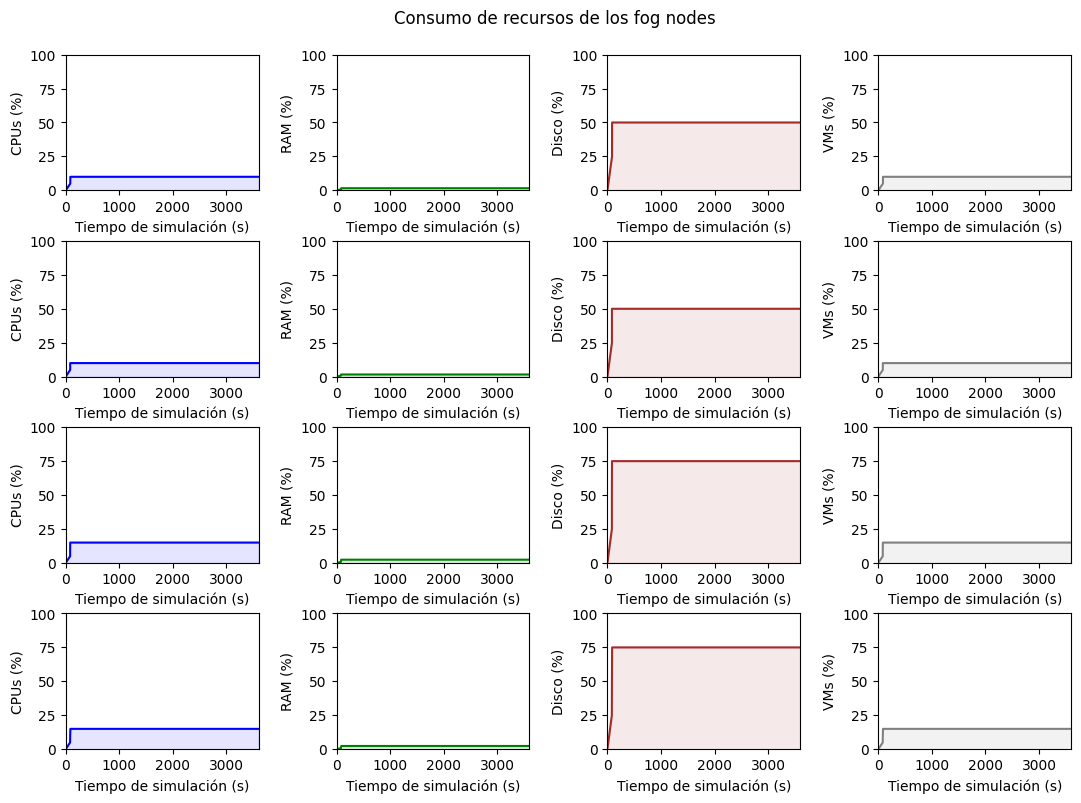

In [95]:
fig, axs = plt.subplots(4, 4,figsize=(10,7)) #sharey=True)
fig.suptitle('Consumo de recursos de los fog nodes')
fig.tight_layout()
fig.set_size_inches(11, 8)

for i in range(4):
    axs[i,0].set(ylabel='CPUs (%)')
    axs[i,1].set(ylabel='RAM (%)')
    axs[i,2].set(ylabel='Disco (%)')
    axs[i,3].set(ylabel='VMs (%)')

    plot_under_curve(axs[i,0], res_fog["cpus"][i].index, (res_fog["cpus"][i].values / fog_max_vms) * 100, "blue")
    plot_under_curve(axs[i,1], res_fog["ram"][i].index, (res_fog["ram"][i].values / fog_max_ram) * 100, "green")
    plot_under_curve(axs[i,2], res_fog["disk"][i].index, (res_fog["disk"][i].values / fog_max_disk) * 100, "brown")
    plot_under_curve(axs[i,3], res_fog["vms"][i].index, (res_fog["vms"][i].values / fog_max_vms) * 100, "gray")

for x in axs.flat:
    x.set_ylim(0,100)
    x.set_xlim(0,3600)
    x.set(xlabel='Tiempo de simulación (s)')